## Line-of-Sight Visibility Analysis
This notebook demonstrates how to compute visible areas from a viewpoint or multiple points using:
- Fast approximate visibility (suitable for quick overviews)
- Accurate visibility analysis (respecting occlusions)
- Parallelized visibility from multiple locations

In [ ]:
# Import necessary libraries
from objectnat import get_visibility, get_visibility_accurate
import geopandas as gpd
from shapely.geometry import Point

### 1. Load Obstacle Data
Load a building layer representing line-of-sight obstacles. This dataset is used to compute occlusions in the urban environment.


In [ ]:
# Load buildings as obstacles
obstacles = gpd.read_parquet('examples_data/buildings.parquet')

### 2. Define Viewpoint
Specify the observation point from which visibility will be computed. Coordinates must match the CRS of the obstacles dataset.


In [8]:
# Define a single viewpoint in WGS 84
point_from = gpd.GeoDataFrame(geometry=[Point(30.2312112, 59.9482336)], crs=4326)
radius = 500

### 3. Fast Visibility Calculation
Compute visibility using a fast, approximate method. This is suitable for real-time feedback or exploratory analysis.
**Note:** May produce artifacts (e.g., visibility behind walls).


In [9]:
# Fast visibility (less accurate)
result_fast = get_visibility(point_from, obstacles, view_distance=radius)
# Computes visibility polygon from the viewpoint with a 500-meter radius using low-resolution simulation.

### 4. Accurate Visibility Calculation
Use the more precise `get_visibility_accurate()` function, which simulates occlusion and limited sightlines.
This method is slower but produces more reliable results.


In [10]:
# Accurate visibility (includes occlusion and bottleneck modeling)
result_accurate = get_visibility_accurate(point_from, obstacles, view_distance=radius)
# Simulates realistic visibility by tracing around buildings and respecting occlusions.

### 5. Visualization
Visualize obstacles and both visibility methods


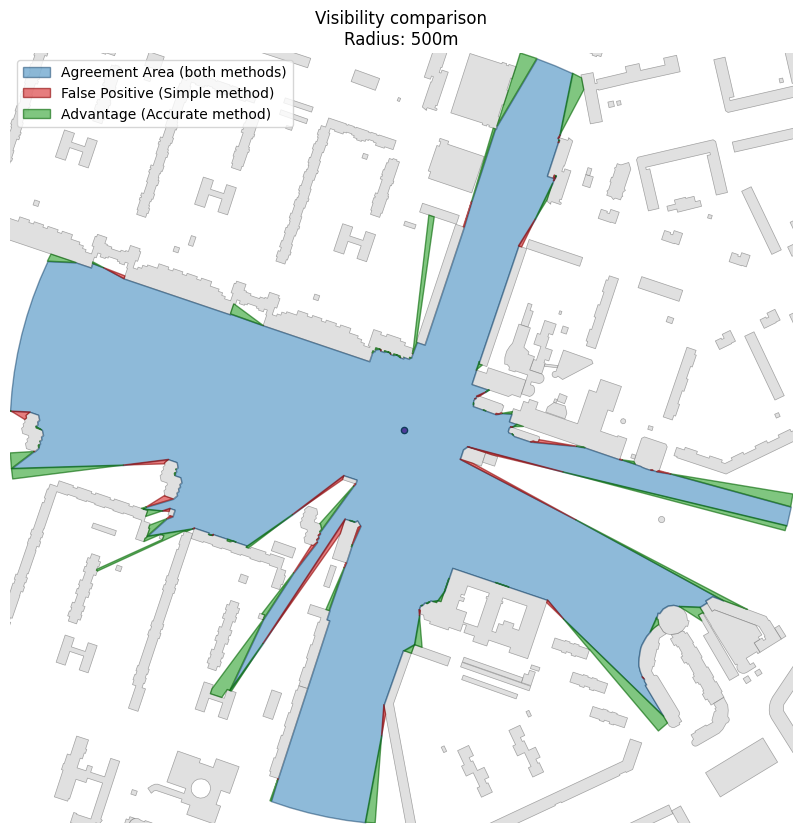

In [12]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from shapely import Point

local_crs = obstacles.estimate_utm_crs()
buildings = obstacles.to_crs(local_crs)
point = point_from.to_crs(local_crs)
simple = result_fast.to_crs(local_crs)
accurate = result_accurate.to_crs(local_crs)

simple_only = gpd.overlay(simple, accurate, how="difference")
accurate_only = gpd.overlay(accurate, simple, how="difference")
common_area = gpd.overlay(simple, accurate, how="intersection")

fig, ax = plt.subplots(figsize=(12, 10))

minx, miny, maxx, maxy = accurate.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

buildings.plot(ax=ax, color="lightgray", alpha=0.7, edgecolor="gray", linewidth=0.5, label="Buildings")

point.plot(ax=ax, color="purple", markersize=20, edgecolor="black", label="Viewpoint")
legend_elements = []

if not common_area.empty:
    style = dict(color="#1f77b4", alpha=0.5, edgecolor="#0d3d66")
    common_area.plot(ax=ax, **style, linewidth=1)
    legend_elements.append(Patch(facecolor="#1f77b4", edgecolor="#0d3d66", alpha=0.5, label="Agreement Area (both methods)"))

if not simple_only.empty:
    style = dict(color="#d62728", alpha=0.6, edgecolor="#8b0000")
    simple_only.plot(ax=ax, **style, linewidth=1)
    legend_elements.append(Patch(facecolor="#d62728", edgecolor="#8b0000", alpha=0.6, label="False Positive (Simple method)"))

if not accurate_only.empty:
    style = dict(color="#2ca02c", alpha=0.6, edgecolor="#006400")
    accurate_only.plot(ax=ax, **style, linewidth=1)
    legend_elements.append(Patch(facecolor="#2ca02c", edgecolor="#006400", alpha=0.6, label="Advantage (Accurate method)"))

ax.set_title(f"Visibility comparison\n" f"Radius: {radius}m")
ax.legend(handles=legend_elements, loc="upper left")
ax.set_axis_off()

plt.show()

### 6. Visibility from Multiple Viewpoints (Parallelized)
For batch visibility simulation, use `get_visibilities_from_points()` with multiple locations.
The computation is performed in parallel using multiprocessing.

In [ ]:
from objectnat import get_visibilities_from_points

obstacles = gpd.read_parquet('examples_data/buildings.parquet')
points = gpd.GeoDataFrame(
    geometry=[Point(30.27060176, 59.93546846), Point(30.29586657, 59.94410918), Point(30.2312112, 59.9482336)],
    crs=4326)

local_crs = obstacles.estimate_utm_crs()
obstacles.to_crs(local_crs, inplace=True)
points.to_crs(local_crs, inplace=True)

result = get_visibilities_from_points(points, obstacles, 500)
# Calculating visibility from each point in the 'points' GeoDataFrame with a view distance of 500 units.
# This method uses multiprocessing for better performance when dealing with multiple points.

gpd.GeoDataFrame(geometry=result, crs=local_crs).explore()

## Calculate visibility catchment area (multiprocessing)

In [ ]:

import pandas as pd
import geopandas as gpd
from objectnat import calculate_visibility_catchment_area

# Load data for buildings, points, woods, and bridges
builds = gpd.read_file('builds.geojson').to_crs(32636)
points = gpd.read_file('distributed_points.geojson').to_crs(32636)
woods = gpd.read_file('woods.geojson').to_crs(32636)
bridges = gpd.read_file('bridges.geojson').to_crs(32636)

view_dist = 1000
# Setting the visibility distance (catchment radius) to 1000 units.

obstacles = gpd.GeoDataFrame(pd.concat([builds, woods, bridges], ignore_index=True), geometry='geometry',
                             crs=32636)
# Combining the GeoDataFrames for buildings, woods, and bridges into a single GeoDataFrame that serves as obstacles 
# to be considered in the visibility calculation.

res = calculate_visibility_catchment_area(points, obstacles, view_dist)
# Calculating the visibility catchment area for the given points, considering the obstacles and the view distance.
# The result is a GeoDataFrame containing the catchment areas.

In [ ]:
res.explore(
    column="factor_normalized",
    categorical=False,
    cmap="plasma",
    legend=True,
)
# Visualizing the catchment areas on an interactive map, using the 'factor_normalized' column to color the areas
# with a 'plasma' colormap. A legend is displayed to show the range of values.